#**Ex.4 HW3 - Training DCGAN and WGAN with pytorch**

# **Hyperparameters**

In [47]:
# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
n_D = 1 #
MNISTtype = 1 # 1 for FashionMNIST Dataset, otherwise digits


# General Setup
This section includes general/pre-code part

Mounting the drive

In [48]:
from google.colab import drive
drive.mount('/content/drive/')
folderpath = '/content/drive/My Drive/DL_TAU2019/ex3_300746930_034915504/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Install and import all the req. lib.

In [49]:
!pip install torch numpy torchvision matplotlib tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import random
import torchvision.utils as vutils
import matplotlib.animation as animation

manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# Connect to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device != "cpu":
  print("GPU is available")
else:
  print("Work on CPU")

Random Seed:  999
GPU is available


Dataset loading

In [50]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
if MNISTtype == 1:
  train_dataset = dsets.FashionMNIST(root='./data',
                            transform=transforms.ToTensor(),
                            download=True)


else:
  train_dataset = dsets.MNIST(root='./data',
                            transform=transforms.ToTensor(),
                            download=True)

# Data Loader
dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)



Make sure that it is Fashion

5


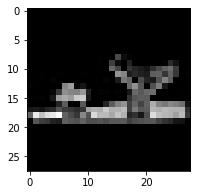

In [51]:
print(train_dataset[-1][1])
img = train_dataset[-1][0]
# get one image
img = np.squeeze(img[0])
fig = plt.figure(figsize = (3,3)) 
plt.imshow(img, cmap='gray')

**DCGAN classes**
Encoder - for a given image the encoder generats a latent vector

In [52]:
class Generator(nn.Module):

  def __init__(self, nz, ngf):

      super().__init__()
      GenFet = ngf
      # 1st layer (3x3img)
      self.conv1 = nn.ConvTranspose2d(nz, GenFet*8,3,1,0,bias=False)
      self.batch1 = nn.BatchNorm2d(GenFet*8)

      # 2nd layer  (7x7img)
      self.conv2 = nn.ConvTranspose2d(GenFet*8, GenFet*4,3,2,0,bias=False)
      self.batch2 = nn.BatchNorm2d(GenFet*4)
      # 3rd layer (14x14img)
      self.conv3 = nn.ConvTranspose2d(GenFet*4, GenFet*2,4,2,1,bias=False)
      self.batch3 = nn.BatchNorm2d(GenFet*2)
      # 4th layer (28x28img)
      self.conv4 = nn.ConvTranspose2d(GenFet*2, GenFet,4,2,1,bias=False)
      self.batch4 = nn.BatchNorm2d(GenFet)

      #5th Layer
      self.conv5 = nn.ConvTranspose2d(GenFet, 1,3,1,1,bias=False)

  def forward(self, x):
      x = F.relu(self.batch1(self.conv1(x)))
      x = F.relu(self.batch2(self.conv2(x)))
      x = F.relu(self.batch3(self.conv3(x)))
      x = F.relu(self.batch4(self.conv4(x)))
      x = self.conv5(x)
      out = torch.sigmoid(x)


      return out

Discriminator Class

In [53]:
class Discriminator(nn.Module):

  def __init__(self, ndf):

      super().__init__()
      # 1st layer 1x(28x28)
      GenFet = ndf
      self.conv1 = nn.Conv2d(1, GenFet,4,2,1,bias=False)
      self.batch1 = nn.BatchNorm2d(GenFet)

      # 2nd layer  (14x14img)
      self.conv2 = nn.Conv2d(GenFet, GenFet*2,4,2,1,bias=False)
      self.batch2 = nn.BatchNorm2d(GenFet*2)
      # 3rd layer (14x14img)
      self.conv3 = nn.Conv2d(GenFet*2, GenFet*4,3,2,0,bias=False)
      self.batch3 = nn.BatchNorm2d(GenFet*4)
      # 4th layer (1x1img)
      self.conv4 = nn.Conv2d(GenFet*4, GenFet*8,3,1,0,bias=False)
      self.batch4 = nn.BatchNorm2d(GenFet*8)

      #5th layer
      self.conv5 = nn.Conv2d(GenFet*8,1,1,1,0,bias=False)
      self.fc = nn.Linear(GenFet*8,1)
      
  def forward(self, x):
      x = self.batch1(self.conv1(x))
      x = F.leaky_relu(self.batch2(self.conv2(x)), 0.2, True)
      x = F.leaky_relu(self.batch3(self.conv3(x)), 0.2, True)
      x = F.leaky_relu(self.batch4(self.conv4(x)), 0.2, True)
      x = self.conv5(x)
      # x = self.fc(x.view(-1,ndf*8))
      out = torch.sigmoid(x)

      return out

In [54]:
class critic(nn.Module):

  def __init__(self, ndf):

      super().__init__()
      # 1st layer 1x(28x28)
      GenFet = ndf
      self.conv1 = nn.Conv2d(1, GenFet,4,2,1,bias=False)
      self.batch1 = nn.BatchNorm2d(GenFet)

      # 2nd layer  (14x14img)
      self.conv2 = nn.Conv2d(GenFet, GenFet*2,4,2,1,bias=False)
      self.batch2 = nn.BatchNorm2d(GenFet*2)
      # 3rd layer (14x14img)
      self.conv3 = nn.Conv2d(GenFet*2, GenFet*4,3,2,0,bias=False)
      self.batch3 = nn.BatchNorm2d(GenFet*4)
      # 4th layer (1x1img)
      self.conv4 = nn.Conv2d(GenFet*4, GenFet*8,3,1,0,bias=False)
      self.batch4 = nn.BatchNorm2d(GenFet*8)

      #5th layer
      self.conv5 = nn.Conv2d(GenFet*8,1,1,1,0,bias=False)
      self.fc = nn.Linear(GenFet*8,1)
      
  def forward(self, x):
      x = self.batch1(self.conv1(x))
      x = F.leaky_relu(self.batch2(self.conv2(x)), 0.2, True)
      x = F.leaky_relu(self.batch3(self.conv3(x)), 0.2, True)
      x = F.leaky_relu(self.batch4(self.conv4(x)), 0.2, True)
      x = self.conv5(x)
      # x = self.fc(x.view(-1,ndf*8))
      # out = torch.sigmoid(x)
      out = x
      return out

# DCGAN - Training

In [55]:
# Create the generator
netG = Generator(nz,ngf).to(device)
netG.apply(weights_init)
# Create the Discriminator
netD = Discriminator(ngf).to(device)
netD.apply(weights_init)
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerD = torch.optim.RMSprop(netD.parameters(),lr = 5e-5)
# optimizerG = torch.optim.RMSprop(netG.parameters(),lr = 5e-5)

In [56]:
# Training Loop for DCGAN

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("++++++++++++++++++++++++++ Training DCGAN ++++++++++++++++++++++++++")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        label = label.type(torch.FloatTensor).to(device)
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        if i % n_D == 0:
          netG.zero_grad()
          label.fill_(real_label)  # fake labels are real for generator cost
          # Since we just updated D, perform another forward pass of all-fake batch through D
          output = netD(fake).view(-1)
          # Calculate G's loss based on this output
          errG = criterion(output, label)
          # Calculate gradients for G
          errG.backward()
          D_G_z2 = output.mean().item()
          # Update G
          optimizerG.step()
          # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1
    print(f'>>epoch {epoch+1}, D_Loss: {errD.item():.5f}, G_Loss: {errG.item():.5f}')
print("++++++++++++++++++++++ Finish Training DCGAN +++++++++++++++++++++++")

++++++++++++++++++++++++++ Training DCGAN ++++++++++++++++++++++++++
>>epoch 1, D_Loss: 1.05597, G_Loss: 1.02386
>>epoch 2, D_Loss: 1.10247, G_Loss: 1.11708
>>epoch 3, D_Loss: 1.16750, G_Loss: 1.08500
>>epoch 4, D_Loss: 1.10865, G_Loss: 1.07136
>>epoch 5, D_Loss: 1.19984, G_Loss: 1.00873
>>epoch 6, D_Loss: 1.24070, G_Loss: 1.00232
>>epoch 7, D_Loss: 1.16996, G_Loss: 1.02786
>>epoch 8, D_Loss: 1.14465, G_Loss: 1.05653
>>epoch 9, D_Loss: 1.15146, G_Loss: 1.19197
>>epoch 10, D_Loss: 1.04043, G_Loss: 1.16965
++++++++++++++++++++++ Finish Training DCGAN +++++++++++++++++++++++


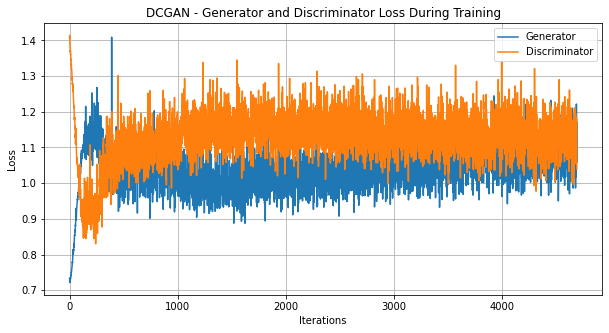

In [57]:
G_DC = netG;
D_DC = netD
torch.save(G_DC.state_dict(), folderpath+'models/DCGANGenerator.pkl')
torch.save(D_DC.state_dict(), folderpath+'models/DCGANDiscriminator.pkl')
plt.figure(figsize=(10,5))
plt.title("DCGAN - Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

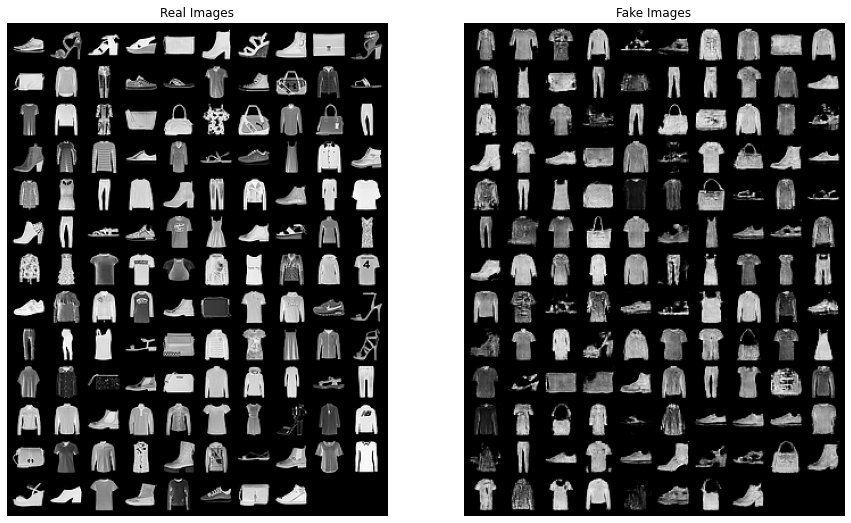

In [58]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), 10,padding=5, normalize=True).cpu(),(1,2,0)), cmap='gray')

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
G_DC.eval()
fake = G_DC(fixed_noise).detach().cpu()
plt.imshow(np.transpose(vutils.make_grid(fake,10,padding=5,normalize=True),(1,2,0)), cmap='gray')

plt.show()

# WGAN Training

In [59]:
# Create the generator
netG = Generator(nz,ngf).to(device)
netG.apply(weights_init)
# Create the Discriminator
netC = critic(ngf).to(device)
netC.apply(weights_init)

# Setup Adam optimizers for both G and C
optimizerC = torch.optim.Adam(netC.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerD = torch.optim.RMSprop(netC.parameters(),lr = 5e-5)
# optimizerG = torch.optim.RMSprop(netG.parameters(),lr = 5e-5)

In [60]:
# Training Loop for WGAN

# Lists to keep track of progress
img_list = []
G_losses = []
C_losses = []
iters = 0

print("++++++++++++++++++++++++++ Training WGAN ++++++++++++++++++++++++++")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

      ############################
      # (1) Update C network: 
      ###########################
      netC.zero_grad()
      # Format batch
      real_imgs = data[0].to(device)
      b_size = real_cpu.size(0)
      
      ## Train with all-fake batch
      # Generate batch of latent vectors
      noise = torch.randn(b_size, nz, 1, 1, device=device)
      # Generate fake image batch with G
      fake_imgs = netG(noise).detach()
      C_loss = -torch.mean(netC(real_imgs)) + torch.mean(netC(fake_imgs))
      C_loss.backward()
      # Update C
      optimizerC.step()
      if i % n_D == 0:
        ############################
        # (2) Update C network:
        ###########################

        netG.zero_grad()
        fake_imgs = netG(noise)

        # Calculate G's loss based on this output
        G_loss =  -torch.mean(netC(fake_imgs))
        # Calculate gradients for G
        G_loss.backward()
        # Update G
        optimizerG.step()
        # Save Losses for plotting later
      G_losses.append(G_loss.item())
      C_losses.append(C_loss.item())

      iters += 1
    print(f'>>epoch {epoch+1}, C_Loss: {C_loss.item():.5f}, G_Loss: {G_loss.item():.5f}')
print("++++++++++++++++++++++ Finish Training WGAN +++++++++++++++++++++++")

++++++++++++++++++++++++++ Training WGAN ++++++++++++++++++++++++++
>>epoch 1, C_Loss: -3.22839, G_Loss: -0.95114
>>epoch 2, C_Loss: -4.24744, G_Loss: -2.98575
>>epoch 3, C_Loss: -4.76987, G_Loss: -6.10245
>>epoch 4, C_Loss: -6.24217, G_Loss: -6.87544
>>epoch 5, C_Loss: -7.32326, G_Loss: -11.41296
>>epoch 6, C_Loss: -8.57781, G_Loss: -15.50711
>>epoch 7, C_Loss: -12.94329, G_Loss: -14.73474
>>epoch 8, C_Loss: -15.80035, G_Loss: -24.06552
>>epoch 9, C_Loss: -11.12929, G_Loss: -26.08189
>>epoch 10, C_Loss: -15.48420, G_Loss: -27.07586
++++++++++++++++++++++ Finish Training WGAN +++++++++++++++++++++++


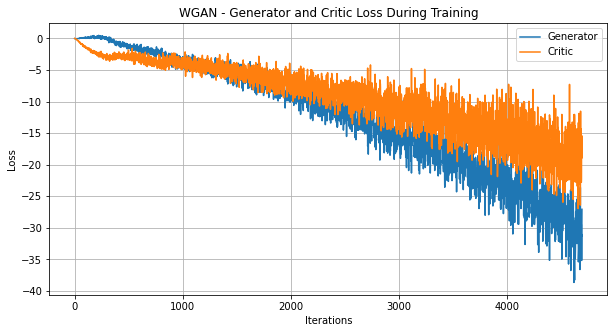

In [61]:
G_W = netG
C_W = netC
torch.save(G_W.state_dict(), folderpath+'models/WGANGenerator.pkl')
torch.save(C_W.state_dict(), folderpath+'models/WGANCritic.pkl')
plt.figure(figsize=(10,5))
plt.title("WGAN - Generator and Critic Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(C_losses,label="Critic")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

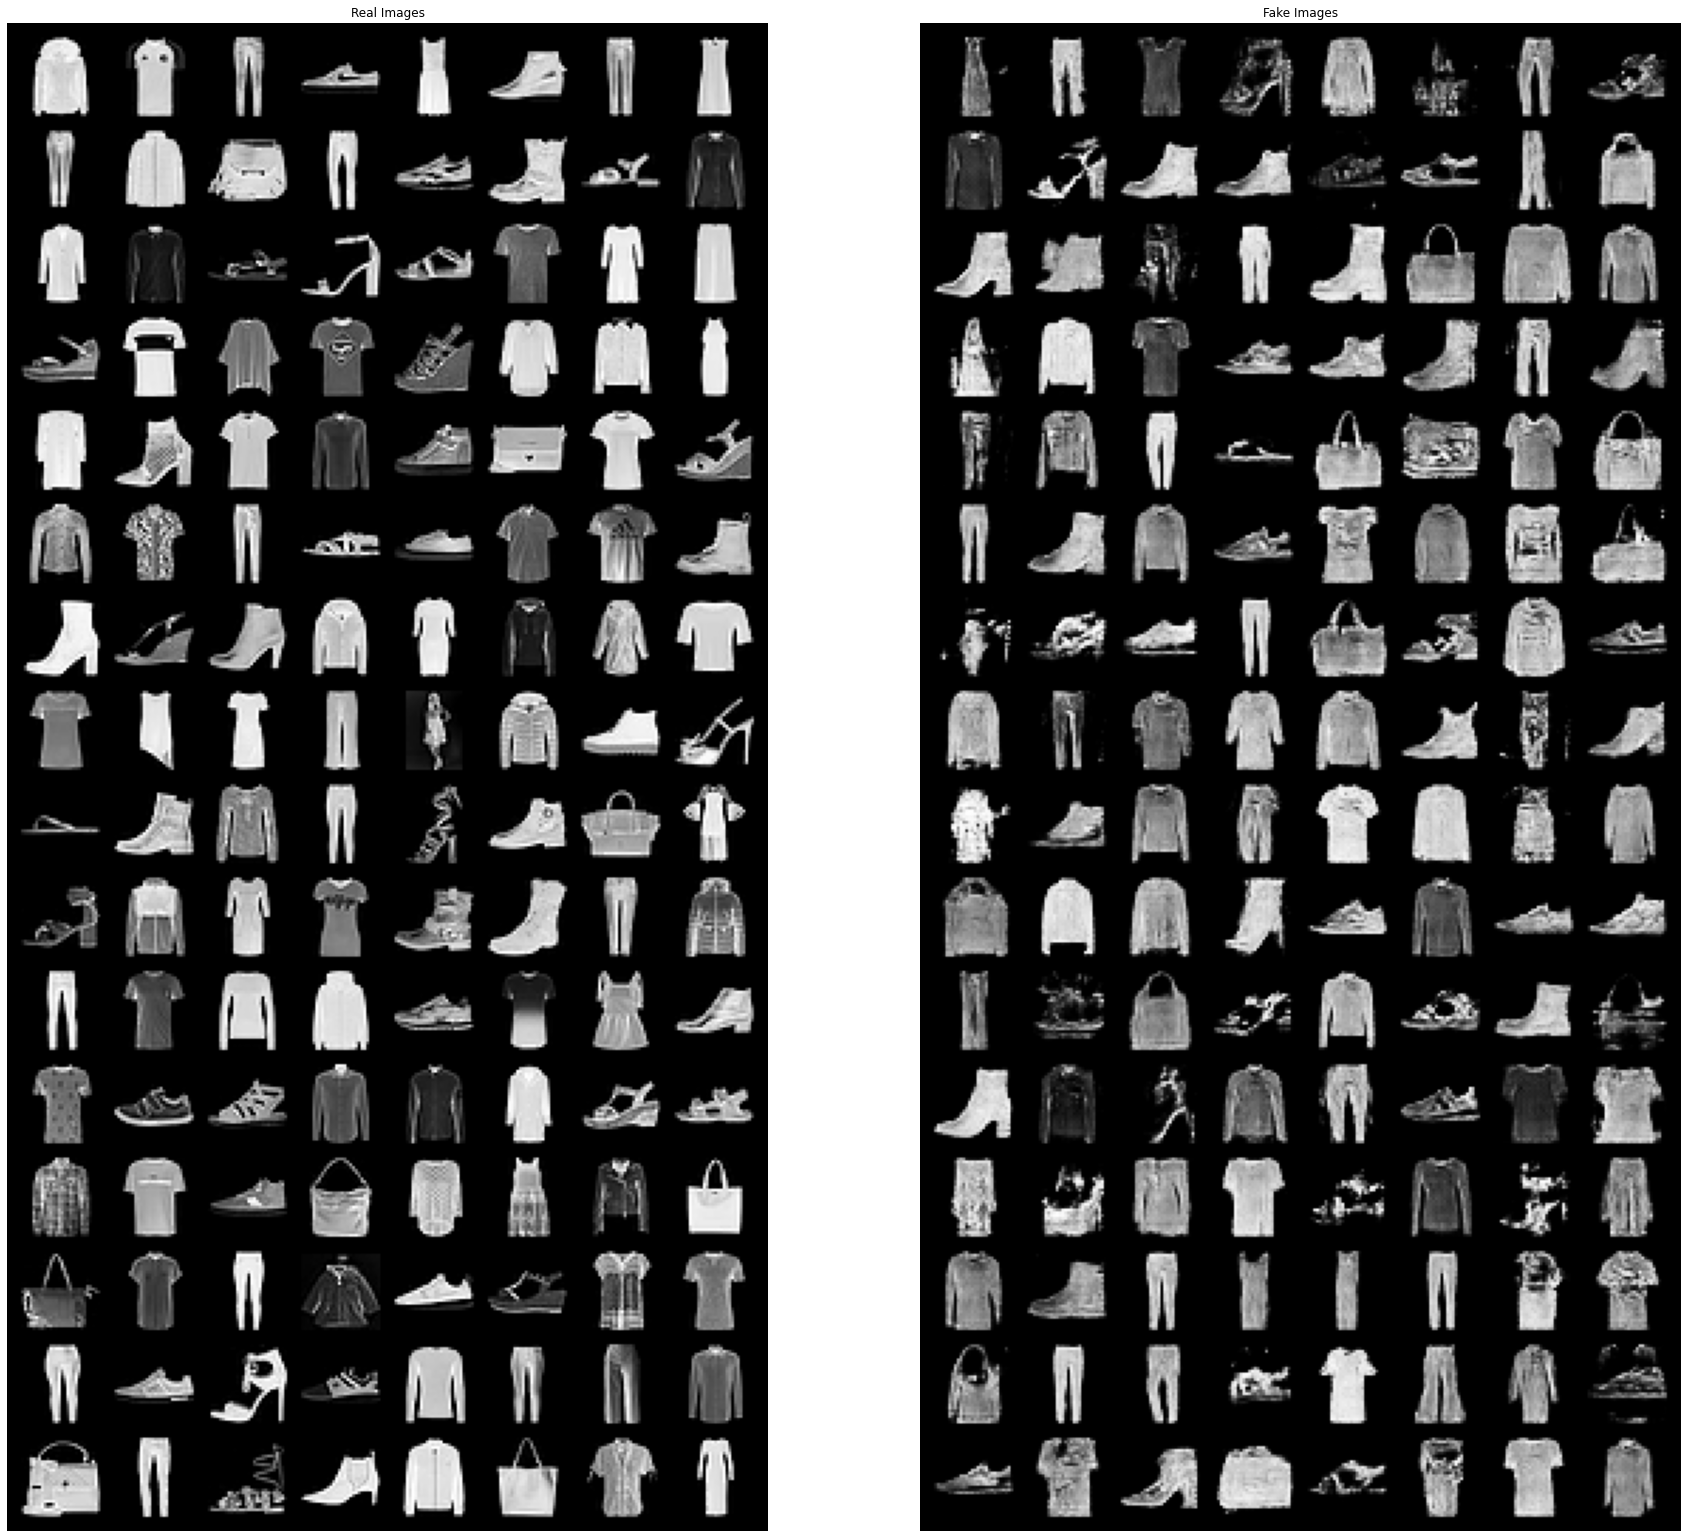

In [62]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=5, normalize=True).cpu(),(1,2,0)), cmap='gray')

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
G_W.eval()
fake = G_W(fixed_noise).detach().cpu()
plt.imshow(np.transpose(vutils.make_grid(fake,padding=5,normalize=True),(1,2,0)), cmap='gray')

plt.show()

# Load models and generat images

load the models

In [63]:
DCGANGenerator = Generator(nz,ngf).to(device)
DCGANGenerator.load_state_dict(torch.load(folderpath+'models/DCGANGenerator.pkl'))

DCGANDiscriminator = Discriminator(ngf).to(device)
DCGANDiscriminator.load_state_dict(torch.load(folderpath+'models/DCGANDiscriminator.pkl'))

WGANGenerator = Generator(nz,ngf).to(device)
WGANGenerator.load_state_dict(torch.load(folderpath+'models/WGANGenerator.pkl'))

WGANCritic = critic(ngf).to(device)
WGANCritic.load_state_dict(torch.load(folderpath+'models/WGANCritic.pkl'))


<All keys matched successfully>

Generate an image

Random Seed:  9118


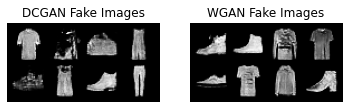

Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (batch1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)


In [65]:
# initiate the seed
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

number_of_images = 8
# Generate a random array
noise = torch.randn(number_of_images, nz, 1, 1, device=device)

DCGANGenerator.eval()
fakeDCGAN = DCGANGenerator(noise).detach().cpu()

WGANGenerator.eval()
fakeWGAN = WGANGenerator(noise).detach().cpu()

plt.figure()
plt.subplot(1,2,1)
plt.axis("off")
plt.title("DCGAN Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fakeDCGAN,4,padding=5,normalize=True),(1,2,0)), cmap='gray')
plt.subplot(1,2,2)
plt.axis("off")
plt.title("WGAN Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fakeWGAN,4,padding=5,normalize=True),(1,2,0)), cmap='gray')

plt.show()
print(DCGANGenerator)